# Project Report: Student Exam Performance
CPSC 310, Spring 2019  
Alli Felger and Angela Rae  
9 May 2019

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import utils

%matplotlib inline

## Introduction
In this project, we looked at how demographic and socioeconomic factors affected highs school student exam scores in reading, writing, and math. We used the Students Performance in Exams dataset obtained from kaggle.com, which includes each student’s gender, race/ethnicity (masked as group A through E), parental level of education, free/reduced lunch status, if the student took a preparation course, and the scores for the three exams. We first analyzed the data using a Naive Bayes classifier and a decision tree, which were fairly inaccurate. We next employed a random forest and a neural network. We found that the neural network was the most accurate of the four classifiers used.

## Exploratory Data Analysis
### Data Set
We used the Students Performance in Exams dataset obtained from kaggle.com. The data is formatted in a csv file and contains 1000 instances. Each record includes a student’s gender (male or female), race/ethnicity (masked as group A, B, C, D, or E), parental level of education (some high school, high school, some college, associate’s degree, bachelor’s degree, master’s degree), lunch (standard, free/reduced), test preparation course (none, completed), math score, writing score, and reading score. Test scores are normalized to integer values between 0 and 100. We used the each of the test scores as the class, ignoring the other two classes as attributes in turn. We also converted the integer score value into letter grades (A-F) and further to pass/fail, where D and above was passing.

One of the challenges with this dataset was that all of its attributes, save for the test scores, were categorical. One of the advantages was that many of the categories were binary (lunch status/test completion/gender), and that was something we wanted to look into in more detail. As our initial plan involved decision trees and forests, we were hopeful that grouping by binary attributes would prove useful.

### Data Visualizations

In [2]:
def make_dot_chart(table, s_att, s_ops, s_labels, chart_title):
    '''
        Create a dot/strip chart of frequency based on att
    '''
    title = "Score Distribution by " + chart_title
    fname = chart_title.lower().replace(' ', '_') + '_plot.pdf'
    m1 = [int(x[-3]) for x in table if x[s_att].strip('"') == s_ops[0]]
    m2 = [int(x[-3]) for x in table if x[s_att].strip('"') == s_ops[1]]

    r1 = [int(x[-2]) for x in table if x[s_att].strip('"') == s_ops[0]]
    r2 = [int(x[-2]) for x in table if x[s_att].strip('"') == s_ops[1]]

    w1 = [int(x[-1]) for x in table if x[s_att].strip('"') == s_ops[0]]
    w2 = [int(x[-1]) for x in table if x[s_att].strip('"') == s_ops[1]]

    gps = [m1, m2, r1, r2, w1, w2]
    y_vals = [[y + 1 for i in range(len(group))] for y, group in enumerate(gps)]

    plt.figure()
    plt.title(title)
    plt.xlabel("Raw Exam Score out of 100")
    avxs = [np.mean(x) for x in gps]
    avys = [y_vals[x][0] for x in range(len(avxs))]
    colors = ['olive', 'purple', 'orange', 'crimson',  'slateblue', 'mediumturquoise']
    for i, g in enumerate(gps):
        plt.scatter(g, y_vals[i], marker='.', s=500, alpha=0.05, color=colors[i])

    plt.scatter(avxs,avys, marker='x', s=250, alpha=1.0, c='black')
    ytks = avys
    ylbs = ['Math-' + s_labels[0], 'Math-' + s_labels[1],
            'Reading-' + s_labels[0], 'Reading-' + s_labels[1],
            'Writing-' + s_labels[0], 'Writing-' + s_labels[1],]
    plt.yticks(ticks=ytks, labels=ylbs)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

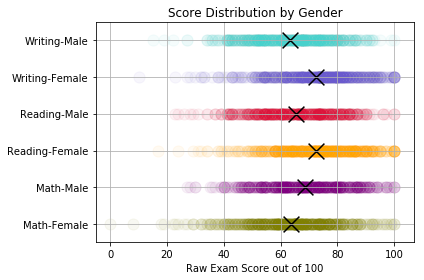

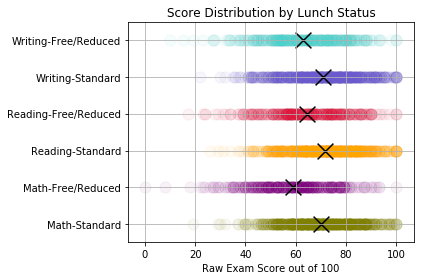

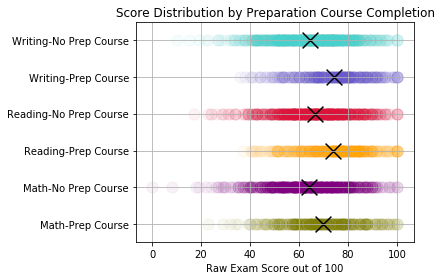

In [3]:
f = 'StudentsPerformance.csv'
students = utils.read_table(f)
h = students[0]
s = students[1:]
make_dot_chart(s, 0, ['female', 'male'], ["Female", "Male"], "Gender")
make_dot_chart(s, 3, ['standard', 'free/reduced'], ["Standard", "Free/Reduced"], "Lunch Status")
make_dot_chart(s, 4, ['completed', 'none'], ["Prep Course", "No Prep Course"], "Preparation Course Completion")

This data was interesting to look at. Math seemed to be the subject that varied the most across all three groupings, while writing and reading seemed very similar to one another. After experimenting with results classifying as grades (A, B, C, D, F), we decided the simplest approach would be to try and predict whether or not a score was passing (>= 60) or failing. This was represented numerically as a 0 for failing and a 1 for passing.

## Classifier Performance

### Naïve Bayes
We first tried to classify "unseen" instances of the dataset using Naive Bayes. To classify an unseen instance, Naive Bayes uses the probability of each class given the known instances. To test the algorithm's accuracy, we use random subsampling over k iterations to create train and test sets, and an average of their accuracies is taken. The Naive Bayes classifier predicts with approximately 62%-65% accuracy. 

In [8]:
from naivebayes import main
main()

-----------------------------------------------------------------
Writing Average Accuracy: 0.6299700598802396
-----------------------------------------------------------------
-----------------------------------------------------------------
Reading Average Accuracy: 0.6293113772455089
-----------------------------------------------------------------
-----------------------------------------------------------------
Math Average Accuracy: 0.6300299401197605
-----------------------------------------------------------------


### Decision Tree Classifier
We made our decision trees based on the same model as PA6. This meant we chose which attrubute to split on by looking at the info gain and maximising. It also used majority voting in the case of splits. This was not the most accurate model in the world, and we hoped to see better results when implementing the random forest.

Our model did the following:
1. Split the set into 10 groups, stratifying the samples so that roughly the same ratio of pass/fail instances were in each group.
1. For each test group, create a TDIDT using the other 9 groups. Then try to classify the instances in the test group. 
1. Track results and output a confusion matrix.

In [1]:
from decision_trees_v3 import main
main()



-----------------------------------------------------------------
              Decision Tree Pass/Fail Predictions
-----------------------------------------------------------------


                       Math Scores
-----------------------------------------------------------------

                        Predicted       
         |-------------------------------------|
         |       |    Yes  |    No   |  Total  |
         |-------------------------------------|
         |   Yes |    601  |     76  |    677  |
  Actual |-------------------------------------|
         |   No  |    231  |     92  |    323  |
         |-------------------------------------|
         | Total |    832  |    168  |   1000  |
         |-------------------------------------|

              Accuracy     : 0.69300
              Standard Err : 0.01459

-----------------------------------------------------------------


                      Reading Scores
-------------------------------------------------

### Random Forest
The random forest expands on the decision tree algorithm, generating a number of trees and using the ensemble to classify unseen instances. To implement the forest, we first use stratified subsampling to generate a test set and remainder. The remainder is split N times using bagging to generate train and validation sets for each tree. After M trees have been generated, the algorithm checks the accuracy of every new tree and saves it only if the accuracy is greater than the minimum saved accuracy.  
After the forest is generated, we classify test instances using all trees in the ensemble. Simple majority voting is used to choose the prediction. We believe it is due to the simple majority voting that the accuracy for predicting writing is so high (usually 95-100%). A more robust voting system may lower the accuracy.

In [10]:
from randomforest import main
main()


 reading score class
                        Predicted       
         |-------------------------------------|
         |       |    Yes  |    No   |  Total  |
         |-------------------------------------|
         |   Yes |    228  |      4  |    232  |
  Actual |-------------------------------------|
         |   No  |     20  |     80  |    100  |
         |-------------------------------------|
         | Total |    248  |     84  |    332  |
         |-------------------------------------|

              Accuracy     : 0.92771
              Standard Err : 0.01421
              Precision : 0.91935
              Recall : 0.98276


 writing score class
                        Predicted       
         |-------------------------------------|
         |       |    Yes  |    No   |  Total  |
         |-------------------------------------|
         |   Yes |    239  |      1  |    240  |
  Actual |-------------------------------------|
         |   No  |      0  |     92  |     92  

### Neural Network
This was our new topic, and one of the more difficult things we attempted. What we ended up with was less a "Neural Network" and more a "Best Neuron" predictor. This was because we did not acheive any hidden layers between input and output, only a single neuron. This way, we were not required to do backpropagation in order to teach the system, we only had to update the weights of the single output neuron. 

Starting this endeavor, we had to convert all of our attributes to numbers. We converted lunch status to 1 (free/reduced) or 2 (standard), preparation course to 0 (no course) or 1 (completed), parents education to 1 (high school degree or some highschool), 2 (associate's degree or some college) or 3 (college or masters degree). We also arbitrarily converted gender to 1(male) and 2(female). We tested whether or not our results varied when these values were swapped, but they did not.  

Our model did the following:
 1. Sort instances by pass/fail, then place into ten different groups, all of which contain roughly the same ratio of pass/fail.
 1. For each group, make up a training set of the other nine. Generate a set of random weights (0-1) with length equal to one less than the instance's length. Then use the training set to modify the weights by subtracting the difference between the classification of a training instance and the dot product of the weight vector with the instance. The factor used to determine how much the weights will be allowed to change each instance, the learning rate, was an interesting variable. We ended up using 0.1, as this was found to be a value that was not so high that the weights would end up oscillating until they reached infinity, nor did they barely move with each modification. Implementing a more precise method for determining a good learning rate would be an interesting extension of this project. 
 1. After the entire training set had been used to obtain the resulting neuron of weights, go back over the training set and attept to classify the instances for every possible threshold (the value below which is 'fail' and above which is 'pass') between 0 and 1. Pick the threshold with the highest accuracy.
 1. Repeat #2 and #3 10 times and return the best weight/threshold set and use it to classify the instances in the test set.
 1. Track overall results and print a confusion matrix.

In [2]:
from perceptron_net import main
main()



-----------------------------------------------------------------
            Perceptron Net Pass/Fail Predictions
-----------------------------------------------------------------


                       Math Scores
-----------------------------------------------------------------

                        Predicted       
         |-------------------------------------|
         |       |    Yes  |    No   |  Total  |
         |-------------------------------------|
         |   Yes |    618  |     59  |    677  |
  Actual |-------------------------------------|
         |   No  |    137  |    186  |    323  |
         |-------------------------------------|
         | Total |    755  |    245  |   1000  |
         |-------------------------------------|

              Accuracy     : 0.80400
              Standard Err : 0.01255

-----------------------------------------------------------------


                      Reading Scores
--------------------------------------------------

## Conclusion
### Our Approach
Overall, we used four different classifiers and obtained four very different sets of results. In order of accuracy, they ranked:

1. Neural Network
1. Random Forest
1. Decision Trees
1. Naïve Bayes

One of our initial questions was whether or not we'd be able to predict the results of one test better than the others. As it turned out, all of the models seemed to predict math scores with less accuracy than reading and writing, whose scores were predicted with roughly the same accurracy. We hypothesize that this correlation could be traced back to the intuitive connection between the two skills, and the fact that the pass/fail status of the other two subjects is included in each model (we'd expect it more likely for someone who passed writing to pass reading as well, and visa versa).

### Improvements
Given more time, we would have liked to implement an actual neural network, not the simplistic single-layer-perceptron model we eneded up with. It just because too difficult in the time we had for the project to fully understand the backpropagation algorithm and hidden layer training enough to effectively use them on our data. Given the results we did get from the perceptron model, we would expect that if we sucessfully implemented a full network it would only improve upon that accuracy. 